# Python File For "airbnb_listings.xlsx" Analysis

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_excel("airbnb_listings.xlsx")
df.head(5)

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaT,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaT,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaT,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,2008-06-26,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,2008-06-26,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [6]:
size = df.size
print("size: ", size)

size:  396214


In [7]:
shape = df.shape
print("shape (rxc) : ",shape)

shape (rxc) :  (30478, 13)


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Host Id                     30478 non-null  int64         
 1   Host Since                  30475 non-null  datetime64[ns]
 2   Name                        30478 non-null  object        
 3   Neighbourhood               30478 non-null  object        
 4   Property Type               30475 non-null  object        
 5   Review Scores Rating (bin)  22155 non-null  float64       
 6   Room Type                   30478 non-null  object        
 7   Zipcode                     30344 non-null  float64       
 8   Beds                        30393 non-null  float64       
 9   Number of Records           30478 non-null  int64         
 10  Number Of Reviews           30478 non-null  int64         
 11  Price                       30478 non-null  int64     

In [62]:
print("\n\n null value count:\n", df.isnull().sum())



 null value count:
 Host Id                          0
Host Since                       3
Name                             0
Neighbourhood                    0
Property Type                    3
Review Scores Rating (bin)    8323
Room Type                        0
Zipcode                        134
Beds                            85
Number of Records                0
Number Of Reviews                0
Price                            0
Review Scores Rating          8323
dtype: int64


In [63]:
df_clean = df.copy()

df_clean['Host Since'].isnull().sum()
df_clean = df_clean.dropna(subset=['Host Since'])

In [64]:
df_clean['Neighbourhood'] = df_clean['Neighbourhood ']
text_columns = ['Neighbourhood', 'Property Type', 'Room Type', 'Zipcode', 'Name']

for col in text_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.lower().str.strip()
        print(f"   Cleaned {col}")

   Cleaned Neighbourhood
   Cleaned Property Type
   Cleaned Room Type
   Cleaned Zipcode
   Cleaned Name


In [65]:
#HANDLE MISSING VALUES

# Remove rows with critical missing data
df_clean = df_clean.dropna(subset=['Host Since', 'Zipcode'])
print(f"   Removed rows missing Host Since and Zipcode")

# Fill numeric missing values with median
numeric_columns = ['Beds', 'Number of Records', 'Number Of Reviews', 'Review Scores Rating', 'Price']

for col in numeric_columns:
    if col in df_clean.columns:
        missing_count = df_clean[col].isnull().sum()
        if missing_count > 0:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"   Filled {missing_count} missing values in {col} with median: {median_val:.1f}")
            
missing_bin_count = df_clean['Review Scores Rating (bin)'].isnull().sum()

if missing_bin_count > 0:
    # Define bin ranges
    def rating_to_bin(rating):
        if pd.isna(rating):
            return np.nan
        elif rating >= 95:
            return '95'
        elif rating >= 90:
            return '90'
        elif rating >= 85:
            return '85'
        elif rating >= 80:
            return '80'
        elif rating >= 75:
            return '75'
        elif rating >= 70:
            return '70'
        else:
            return '65'

    # Fill missing bin values
    mask = df_clean['Review Scores Rating (bin)'].isnull()
    df_clean.loc[mask, 'Review Scores Rating (bin)'] = df_clean.loc[mask, 'Review Scores Rating'].apply(rating_to_bin)

            

   Removed rows missing Host Since and Zipcode
   Filled 85 missing values in Beds with median: 1.0
   Filled 8320 missing values in Review Scores Rating with median: 94.0


In [66]:
# CONVERT DATA TYPES
# Convert to datetime
df_clean['Host Since'] = pd.to_datetime(df_clean['Host Since'], errors='coerce')

# Convert to numeric
for col in numeric_columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    print(f"   Converted {col} to numeric")



   Converted Beds to numeric
   Converted Number of Records to numeric
   Converted Number Of Reviews to numeric
   Converted Review Scores Rating to numeric
   Converted Price to numeric


In [67]:

#REMOVE DUPLICATES
duplicates = df_clean.duplicated().sum()
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"   Removed {duplicates} duplicate rows")
else:
    print("   No duplicates found")

   Removed 17 duplicate rows


In [68]:
# Price categories
df_clean['Price_Category'] = pd.cut(df_clean['Price'], 
                                   bins=[0, 50, 100, 200, 500, float('inf')],
                                   labels=['Budget', 'Economy', 'Standard', 'Premium', 'Luxury'])

# Rating categories
df_clean['Rating_Category'] = pd.cut(df_clean['Review Scores Rating'],
                                    bins=[0, 70, 80, 90, 95, 100],
                                    labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])

# Property size
df_clean['Size_Category'] = pd.cut(df_clean['Beds'],
                                  bins=[0, 1, 2, 3, float('inf')],
                                  labels=['Small', 'Medium', 'Large', 'Extra Large'])

# Extract time features
df_clean['Host_Year'] = df_clean['Host Since'].dt.year
df_clean['Host_Month'] = df_clean['Host Since'].dt.month

#df_clean['Host Since'] = pd.to_datetime(df_clean['Host Since'], errors='coerce')
#df_clean['Host_Year'] = df_clean['Host Since'].dt.year
#df_clean['Host_Month'] = df_clean['Host Since'].dt.month
#df_clean['Host_Day'] = df_clean['Host Since'].dt.day
#df_clean['Host_Weekday'] = df_clean['Host Since'].dt.day_name()

print("   Created: Price_Category, Rating_Category, Size_Category, Time features")

## 7. FINAL CHECK
print("\n7. FINAL DATA SUMMARY:")
print(f"   Final shape: {df_clean.shape}")
print(f"   Missing values: {df_clean.isnull().sum().sum()}")

df_clean.head(3)

   Created: Price_Category, Rating_Category, Size_Category, Time features

7. FINAL DATA SUMMARY:
   Final shape: (30458, 19)
   Missing values: 2


,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,Neighbourhood,Price_Category,Rating_Category,Size_Category,Host_Year,Host_Month
3,500,2008-06-26,gorgeous 1 br with private balcony,Manhattan,apartment,90,entire home/apt,10024.0,3.0,1,0,199,94.0,manhattan,Standard,Very Good,Large,2008,6
4,500,2008-06-26,trendy times square loft,Manhattan,apartment,95.0,private room,10036.0,3.0,1,39,549,96.0,manhattan,Luxury,Excellent,Large,2008,6
5,1039,2008-07-25,big greenpoint 1bd w/ skyline view,Brooklyn,apartment,100.0,entire home/apt,11222.0,1.0,1,4,149,100.0,brooklyn,Standard,Excellent,Small,2008,7


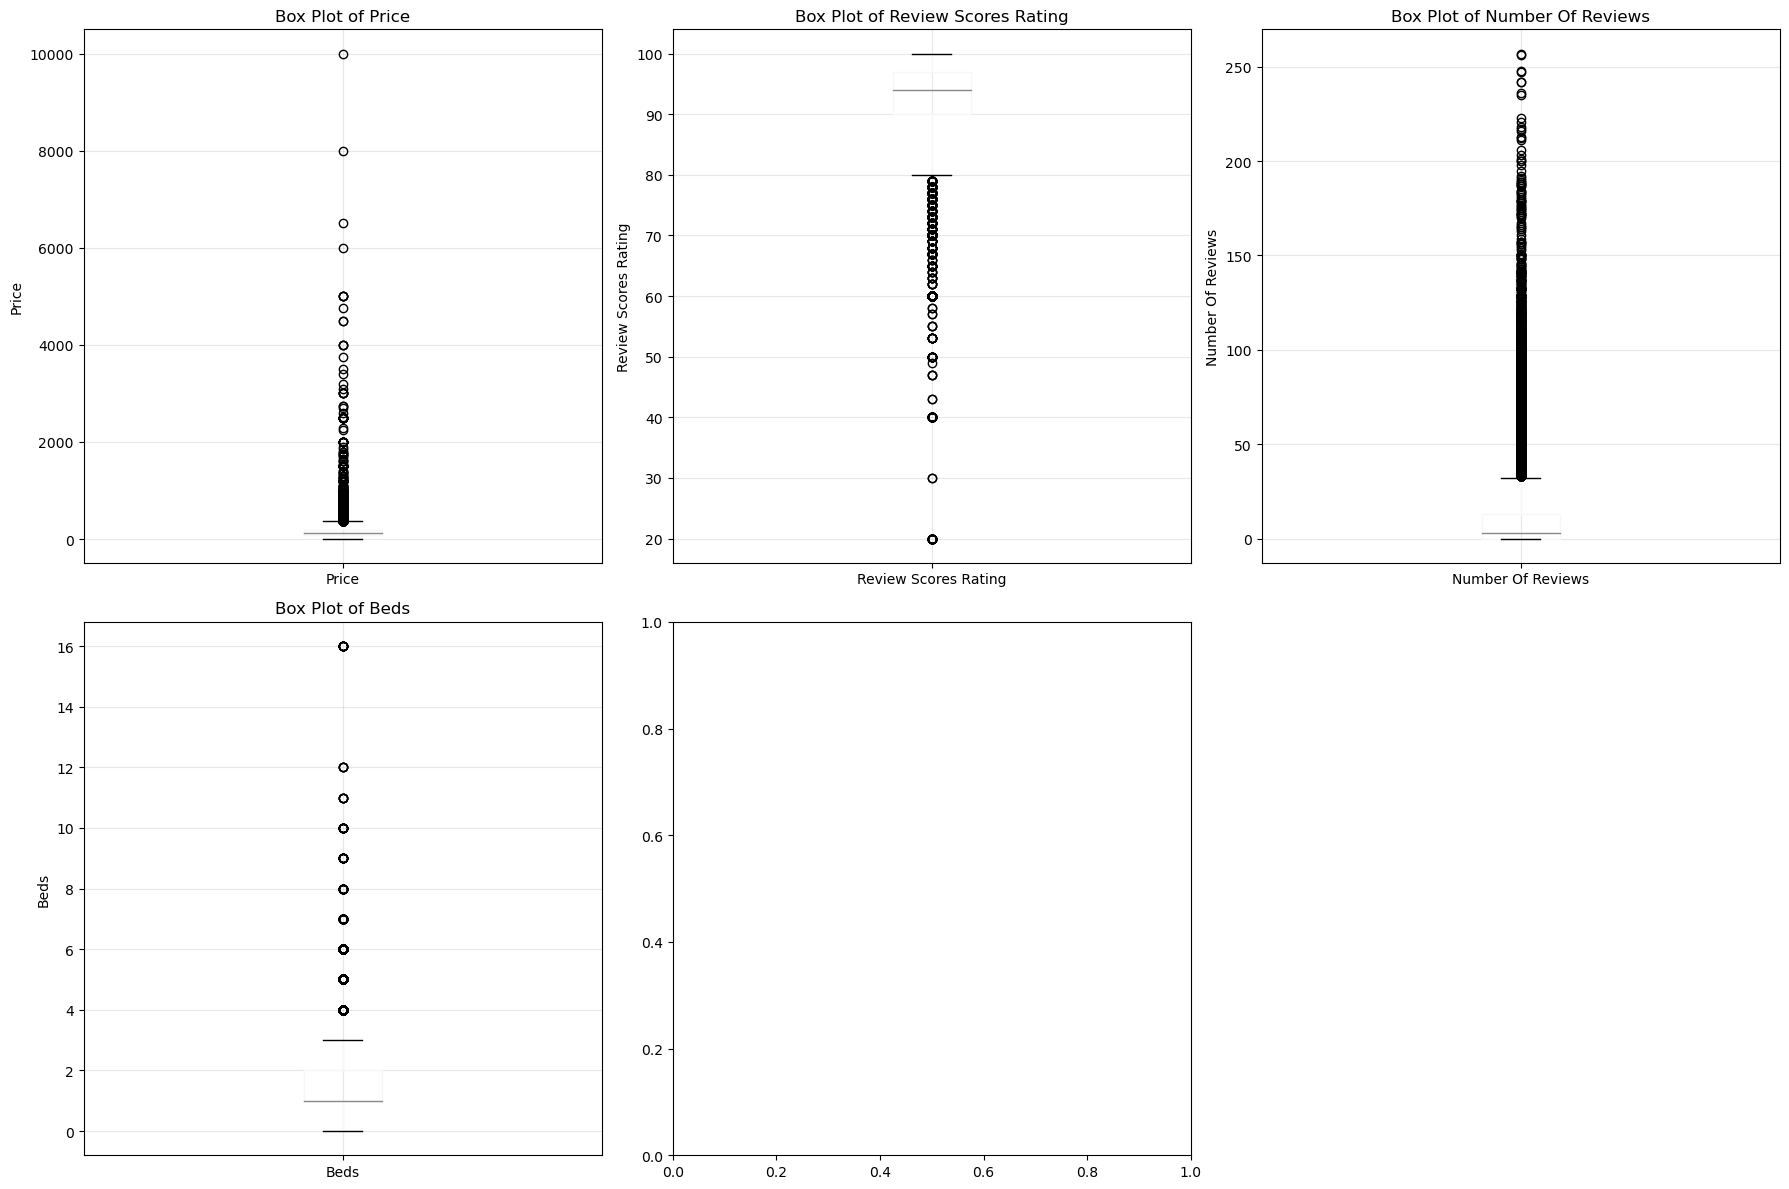

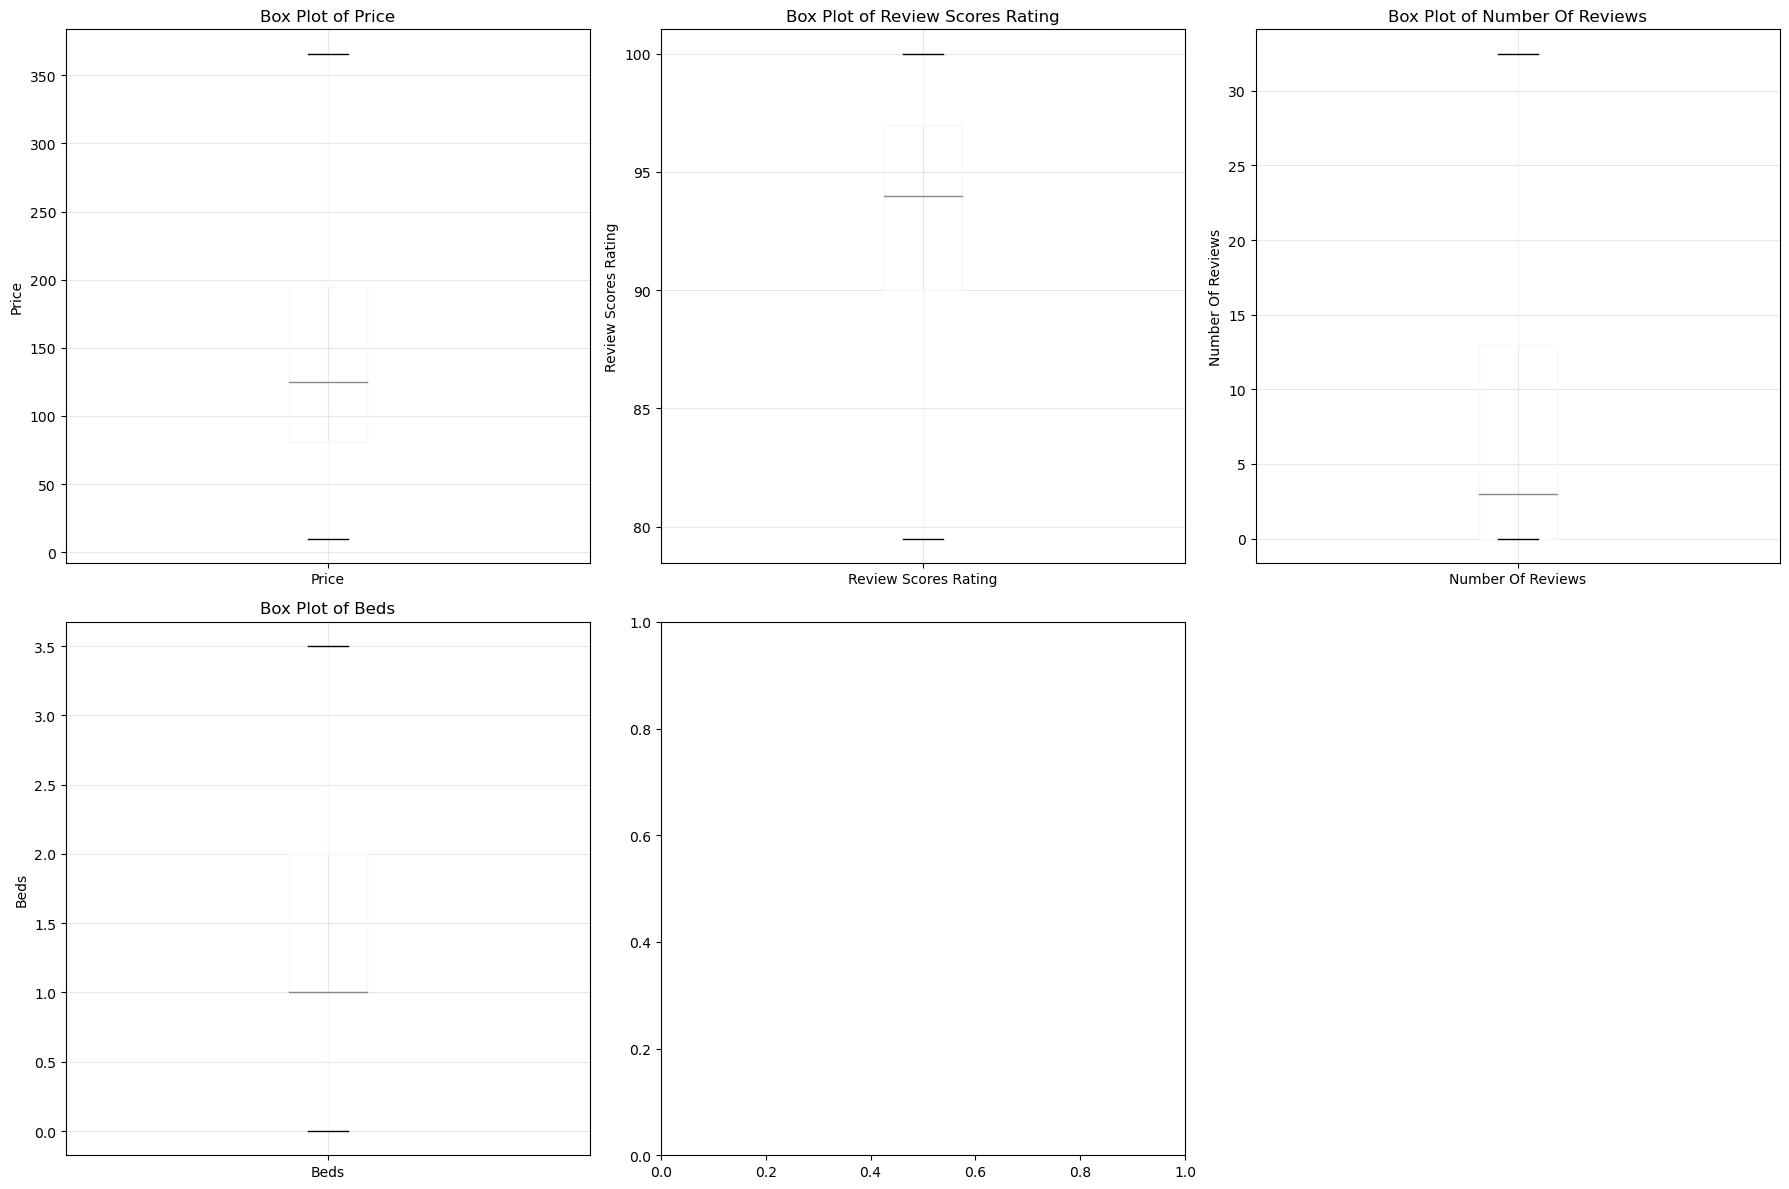

In [23]:
# Create box plots to identify outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    df_clean.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_ylabel(col)
    axes[i].grid(alpha=0.3)

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

for col in numerical_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    outliers_before = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    
    # Cap the outliers
    df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
    df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
    
    # Count outliers after capping
    outliers_after = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
       
# Create box plots to identify outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    df_clean.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_ylabel(col)
    axes[i].grid(alpha=0.3)

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

# Univariate Analysis

In [69]:
plt.style.use('default')
sns.set_palette("husl")

NUMERICAL VARIABLES DISTRIBUTION


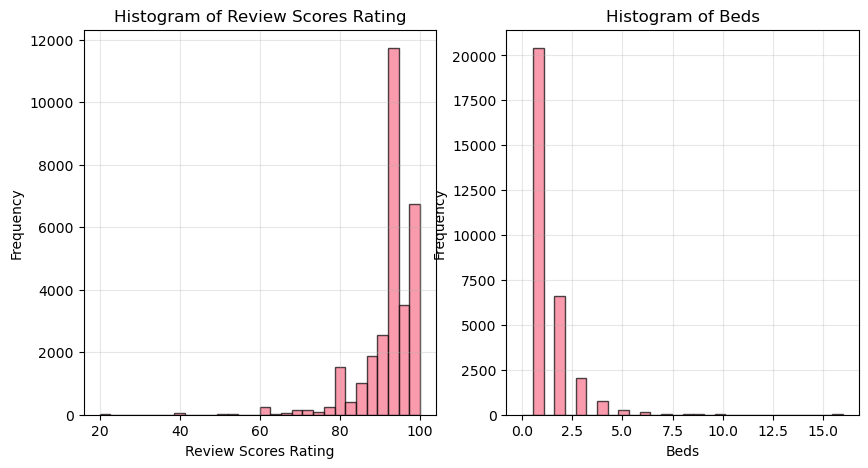

In [87]:
print("NUMERICAL VARIABLES DISTRIBUTION") 
numerical_cols = ['Review Scores Rating', 'Beds']
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    axes[i].hist(df_clean[col], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)



3. CATEGORICAL VARIABLES DISTRIBUTION


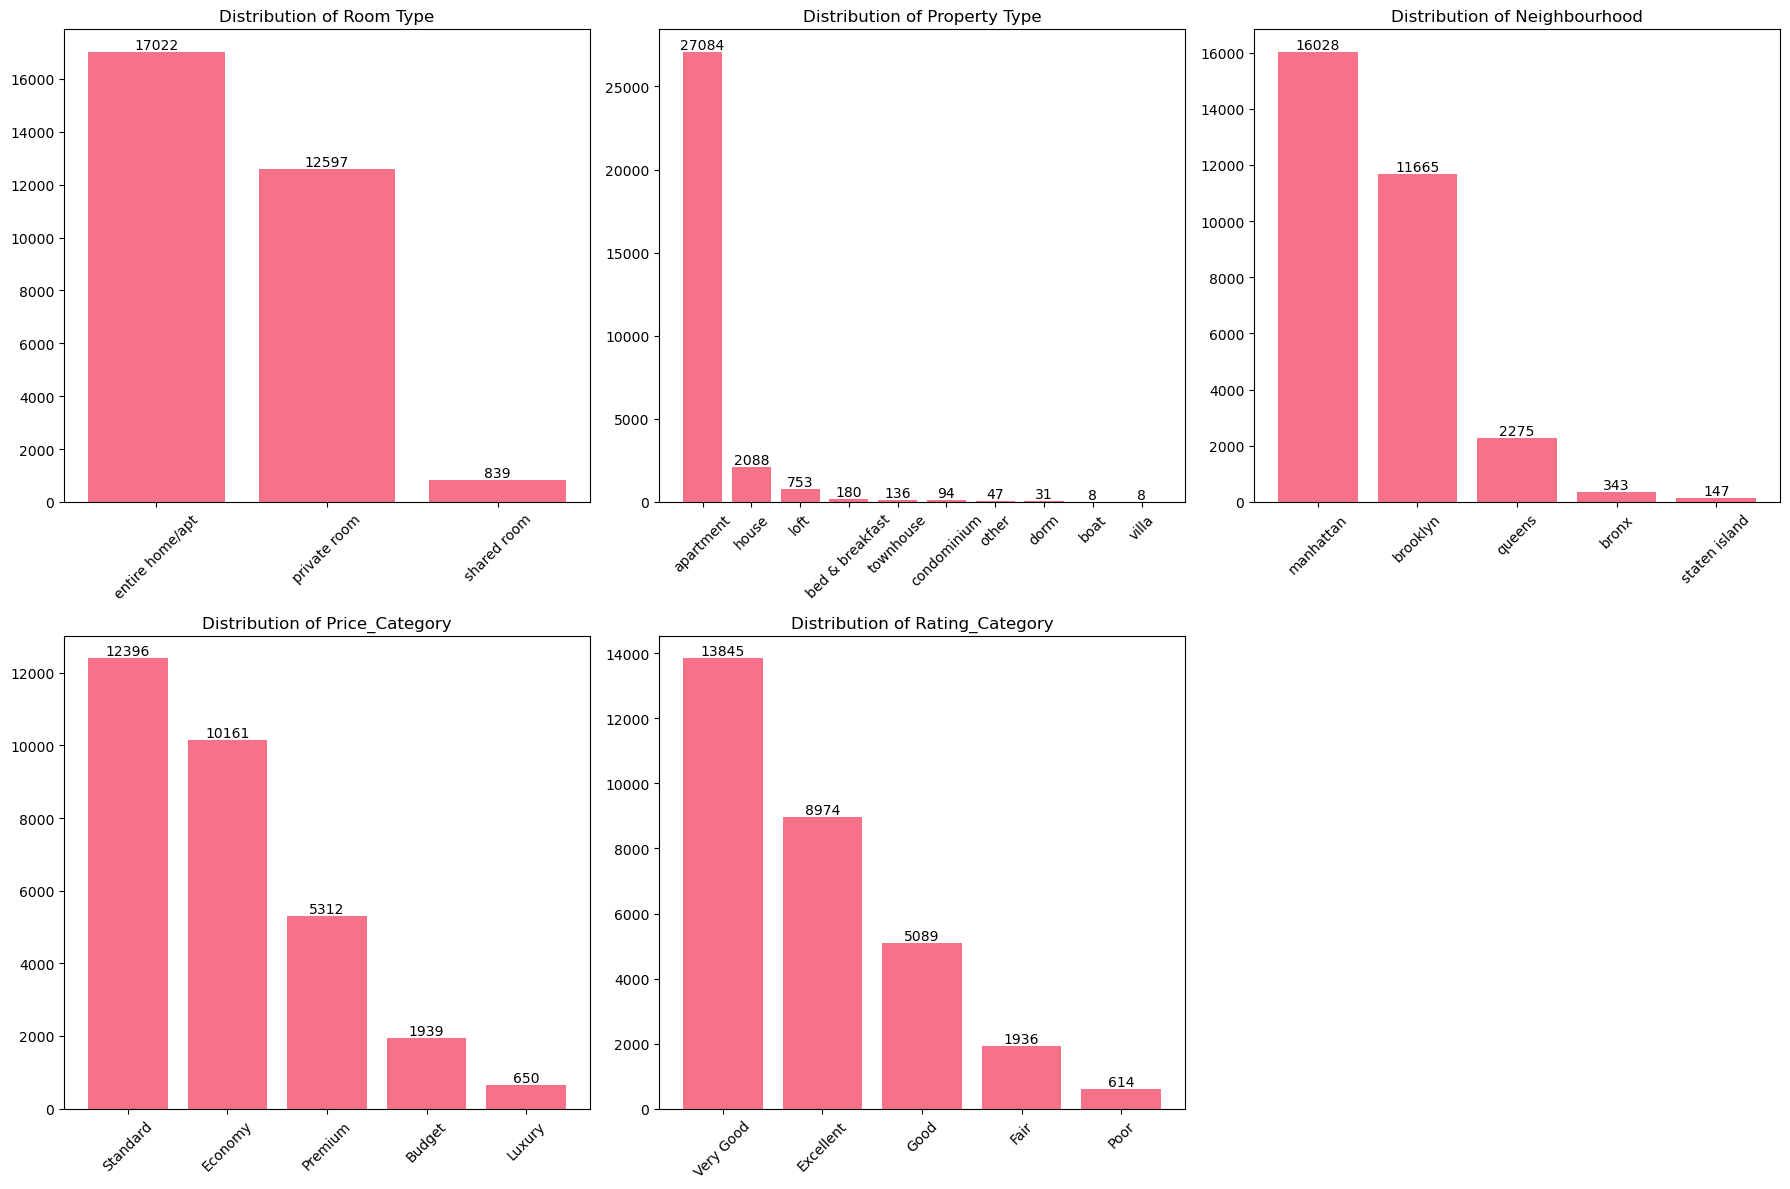

In [72]:
print("CATEGORICAL VARIABLES DISTRIBUTION")

categorical_cols = ['Room Type', 'Property Type', 'Neighbourhood', 'Price_Category', 'Rating_Category']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if col in df_clean.columns:
        # Get top 10 categories for better visualization
        value_counts = df_clean[col].value_counts().head(10)
        if len(value_counts) > 0:
            bars = axes[i].bar(range(len(value_counts)), value_counts.values)
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xticks(range(len(value_counts)))
            axes[i].set_xticklabels(value_counts.index, rotation=45)
            
            # Add value labels on bars
            for bar, count in zip(bars, value_counts.values):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                           f'{count}', ha='center', va='bottom')

# Remove empty subplots
for i in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


5. PIE CHARTS FOR MAIN CATEGORIES


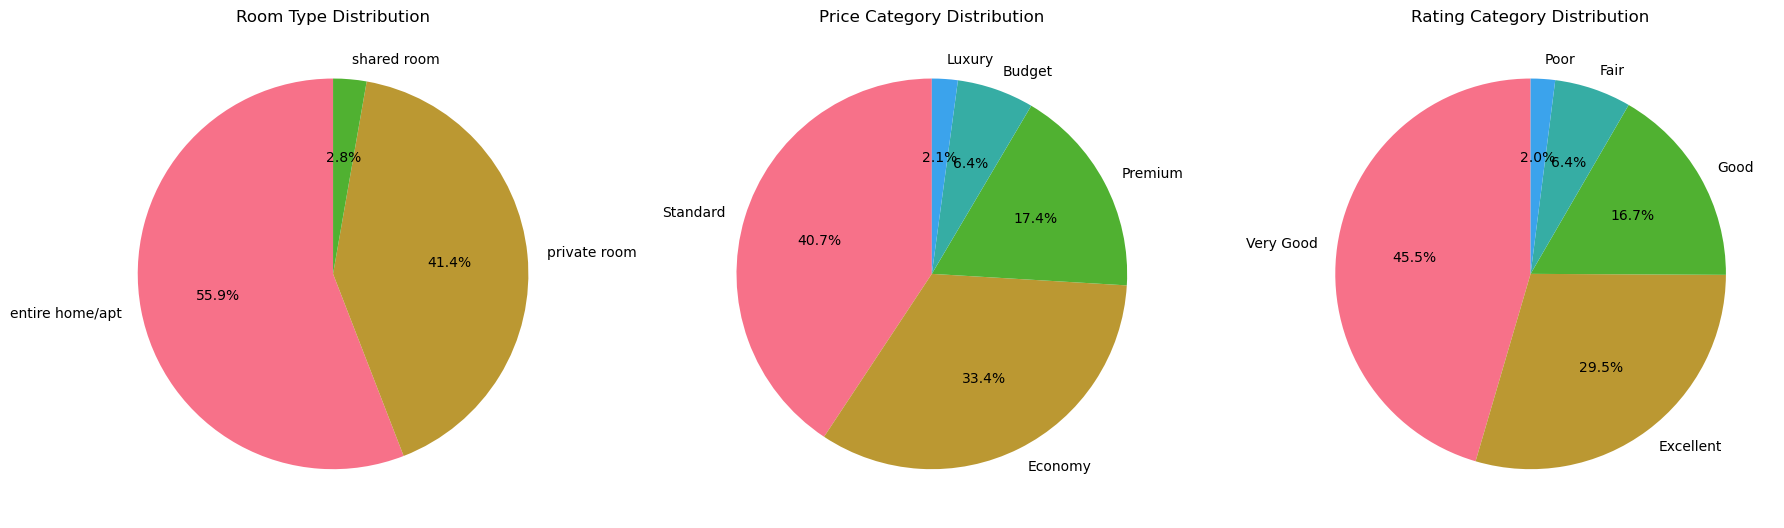

In [74]:
print("\PIE CHARTS FOR MAIN CATEGORIES")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Room Type
room_type_counts = df_clean['Room Type'].value_counts()
axes[0].pie(room_type_counts.values, labels=room_type_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Room Type Distribution')

# Price Category
price_cat_counts = df_clean['Price_Category'].value_counts()
axes[1].pie(price_cat_counts.values, labels=price_cat_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Price Category Distribution')

# Rating Category
rating_cat_counts = df_clean['Rating_Category'].value_counts()
axes[2].pie(rating_cat_counts.values, labels=rating_cat_counts.index, autopct='%1.1f%%', startangle=90)
axes[2].set_title('Rating Category Distribution')

plt.tight_layout()
plt.show()

In [75]:

print("STATISTICAL SUMMARY OF NUMERICAL VARIABLES")
print(df_clean[numerical_cols].describe())

print("VARIABILITY ANALYSIS")
for col in numerical_cols:
    print(f"\n{col}:")
    print(f"  Range: {df_clean[col].min():.2f} to {df_clean[col].max():.2f}")
    print(f"  Standard Deviation: {df_clean[col].std():.2f}")
    print(f"  Coefficient of Variation: {(df_clean[col].std() / df_clean[col].mean() * 100):.2f}%")
    print(f"  Skewness: {df_clean[col].skew():.2f}")


6. STATISTICAL SUMMARY OF NUMERICAL VARIABLES
              Price  Review Scores Rating  Number Of Reviews          Beds
count  30458.000000          30458.000000       30458.000000  30458.000000
mean     163.653753             92.540351          12.026463      1.528662
std      197.830305              7.600360          21.985846      1.014287
min       10.000000             20.000000           0.000000      0.000000
25%       81.000000             90.000000           0.000000      1.000000
50%      125.000000             94.000000           3.000000      1.000000
75%      195.000000             97.000000          13.000000      2.000000
max    10000.000000            100.000000         257.000000     16.000000

7. VARIABILITY ANALYSIS

Price:
  Range: 10.00 to 10000.00
  Standard Deviation: 197.83
  Coefficient of Variation: 120.88%
  Skewness: 15.56

Review Scores Rating:
  Range: 20.00 to 100.00
  Standard Deviation: 7.60
  Coefficient of Variation: 8.21%
  Skewness: -3.06

Number 

In [78]:
#categorical_columns = ['Round','Stadium','City','Country', 'Team', 'Opponent','TeamResult','StageType']

print("\nCategorical Variables Summary:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(s2_clean[col].value_counts().head())
    
        


Categorical Variables Summary:

Room Type:
Room Type
entire home/apt    17022
private room       12597
shared room          839
Name: count, dtype: int64

Property Type:
Property Type
apartment          27084
house               2088
loft                 753
bed & breakfast      180
townhouse            136
Name: count, dtype: int64

Neighbourhood:
Neighbourhood
manhattan        16028
brooklyn         11665
queens            2275
bronx              343
staten island      147
Name: count, dtype: int64

Price_Category:
Price_Category
Standard    12396
Economy     10161
Premium      5312
Budget       1939
Luxury        650
Name: count, dtype: int64

Rating_Category:
Rating_Category
Very Good    13845
Excellent     8974
Good          5089
Fair          1936
Poor           614
Name: count, dtype: int64


# Bivariate & Multivariate Analysis

MARKET ANALYSIS
Pricing trends across different neighborhoods

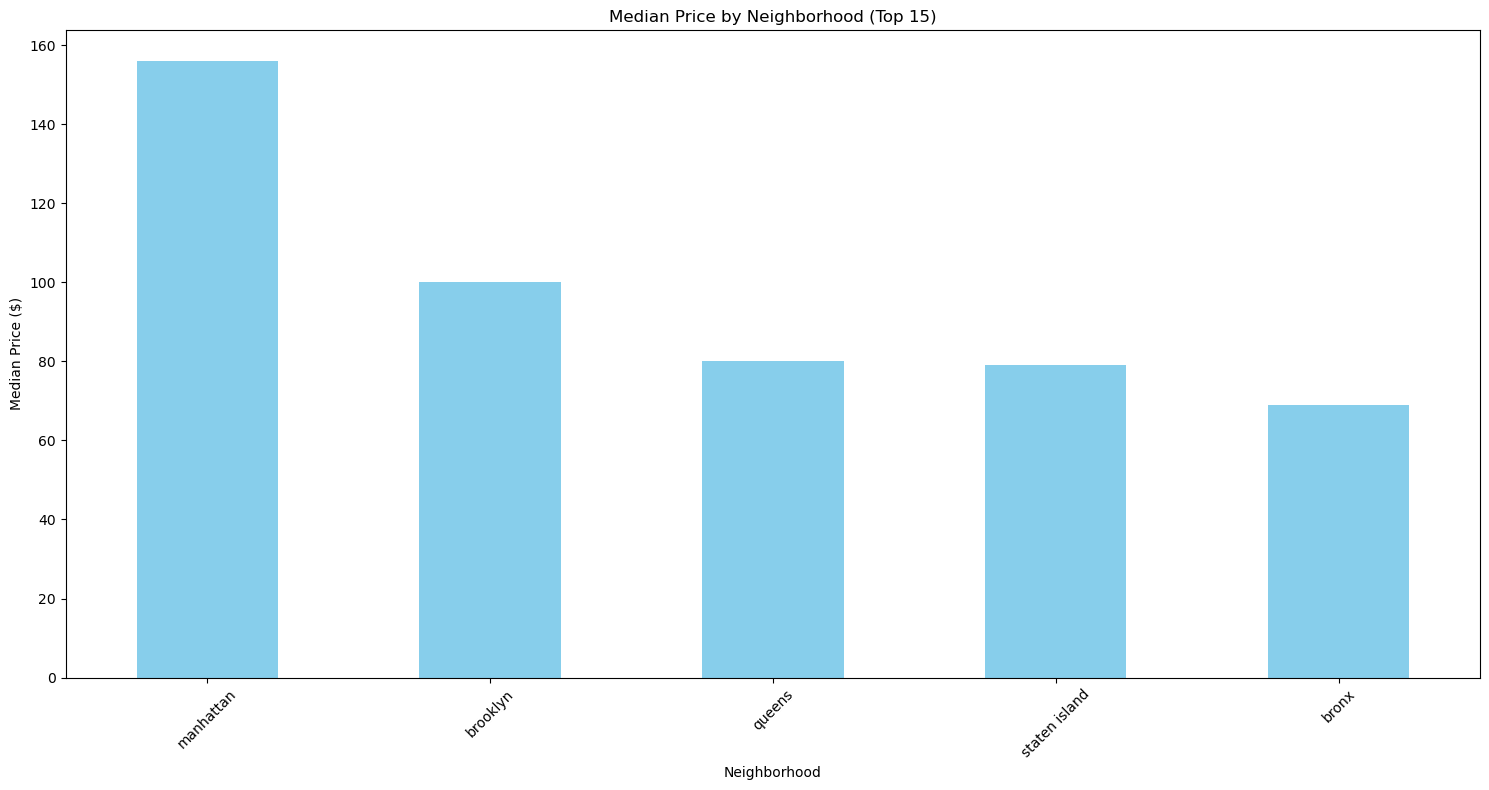

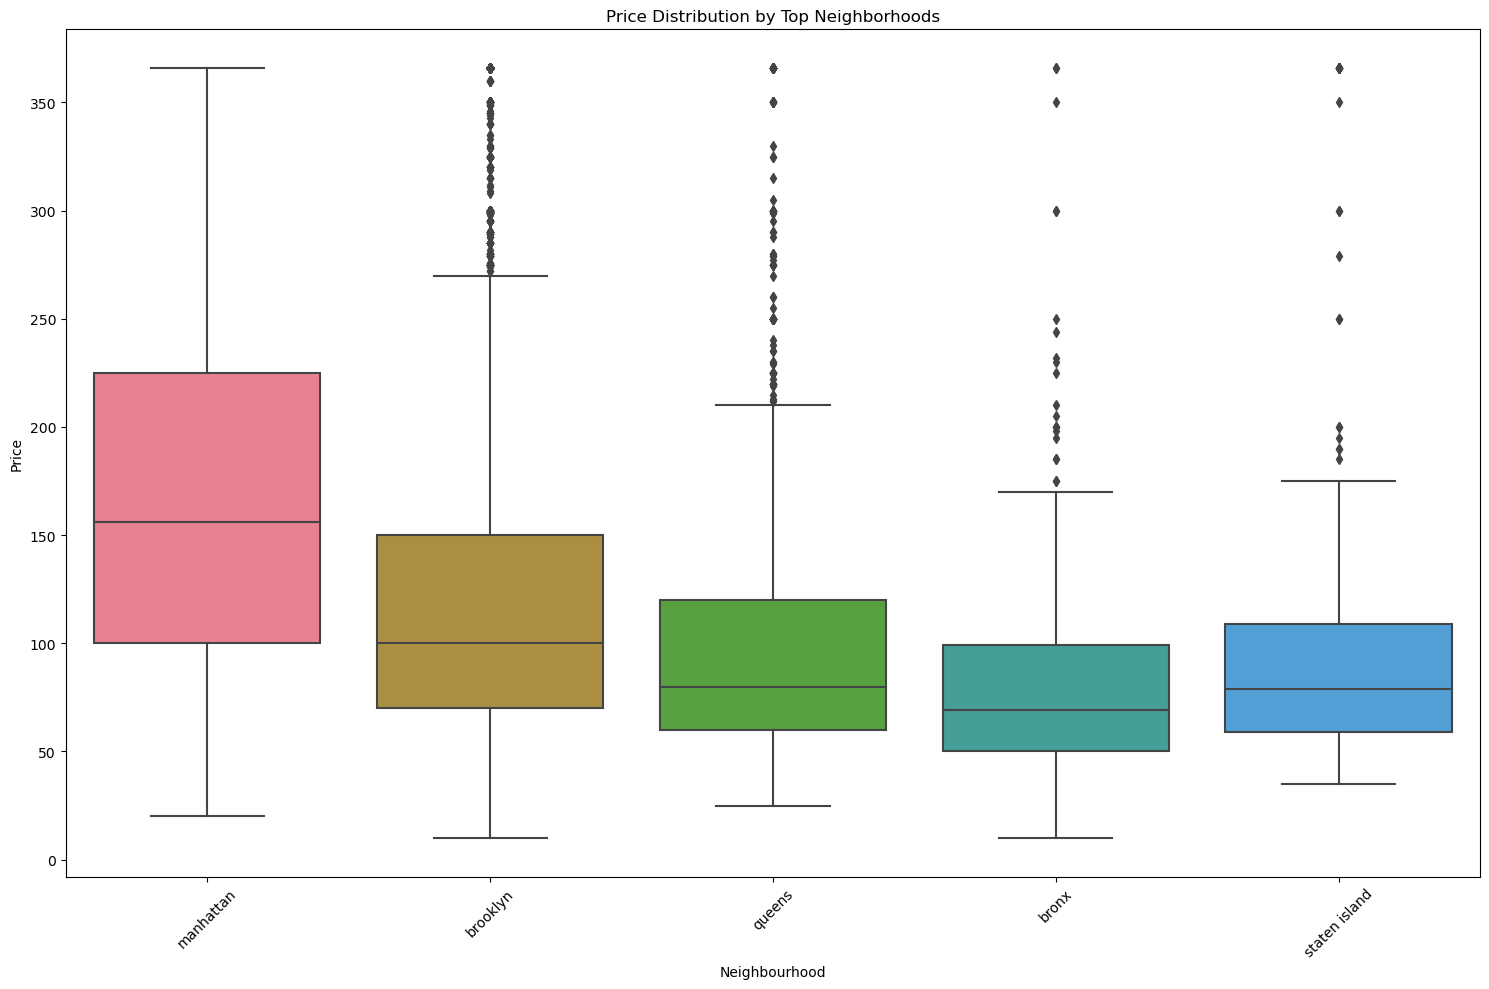

In [27]:
# Price by neighborhood
plt.figure(figsize=(15, 8))
neighborhood_price = df_clean.groupby('Neighbourhood')['Price'].median().sort_values(ascending=False)

# Top 15 neighborhoods by median price
neighborhood_price.head(15).plot(kind='bar', color='skyblue')
plt.title('Median Price by Neighborhood (Top 15)')
plt.xlabel('Neighborhood')
plt.ylabel('Median Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box plot for price distribution by neighborhood
plt.figure(figsize=(15, 10))
top_neighborhoods = df_clean['Neighbourhood'].value_counts().head(10).index
df_top_neigh = df_clean[df_clean['Neighbourhood'].isin(top_neighborhoods)]

sns.boxplot(data=df_top_neigh, x='Neighbourhood', y='Price')
plt.title('Price Distribution by Top Neighborhoods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This visualization is bivarient and represents Pricing trends across different neighborhoods, the histogram
shows that manhattan has highest prices and lowest are of bronx, staten island  and queens have almost same prices distribution
hence by seeing this we can get an idea at glance about neighbiurhood and their respective prices

2. Most popular types of accommodations

<Figure size 1200x800 with 0 Axes>

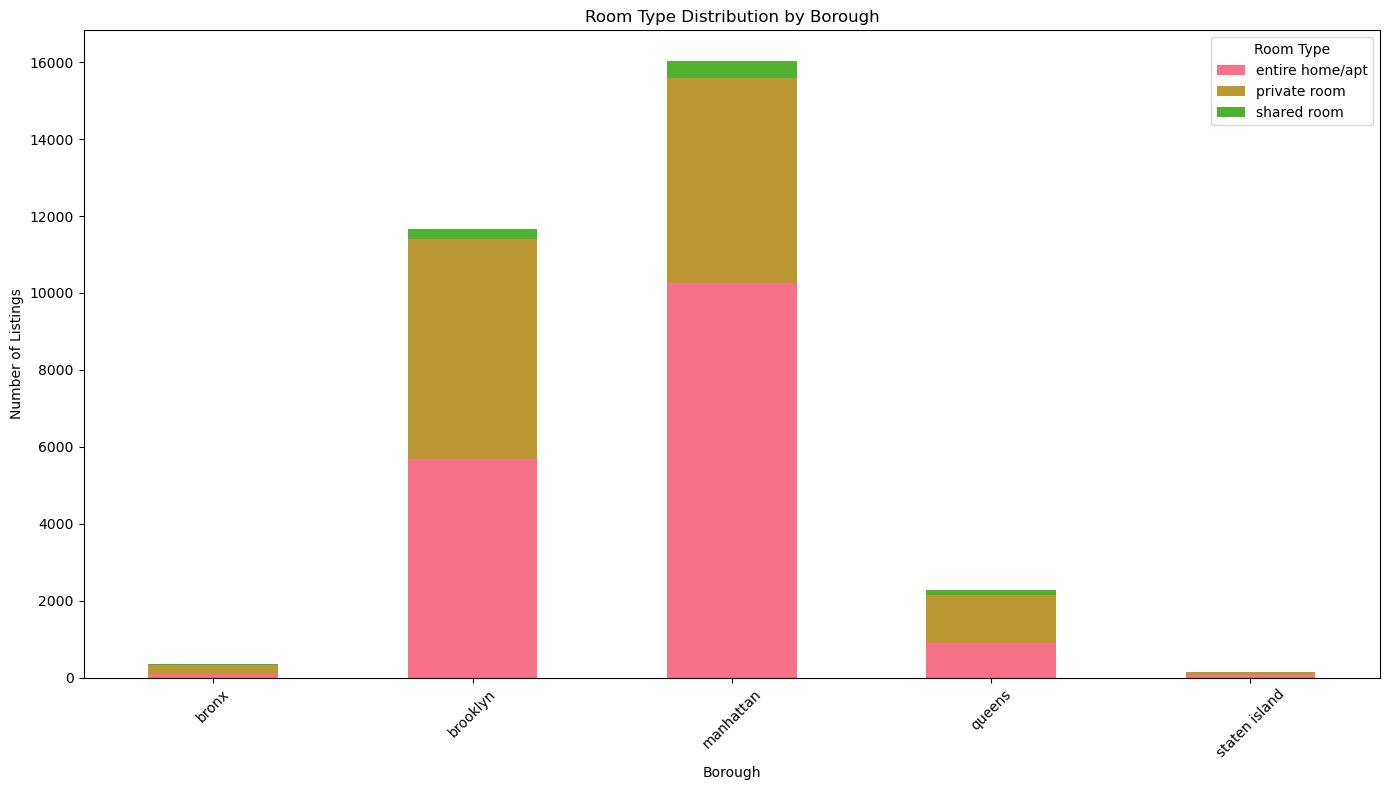

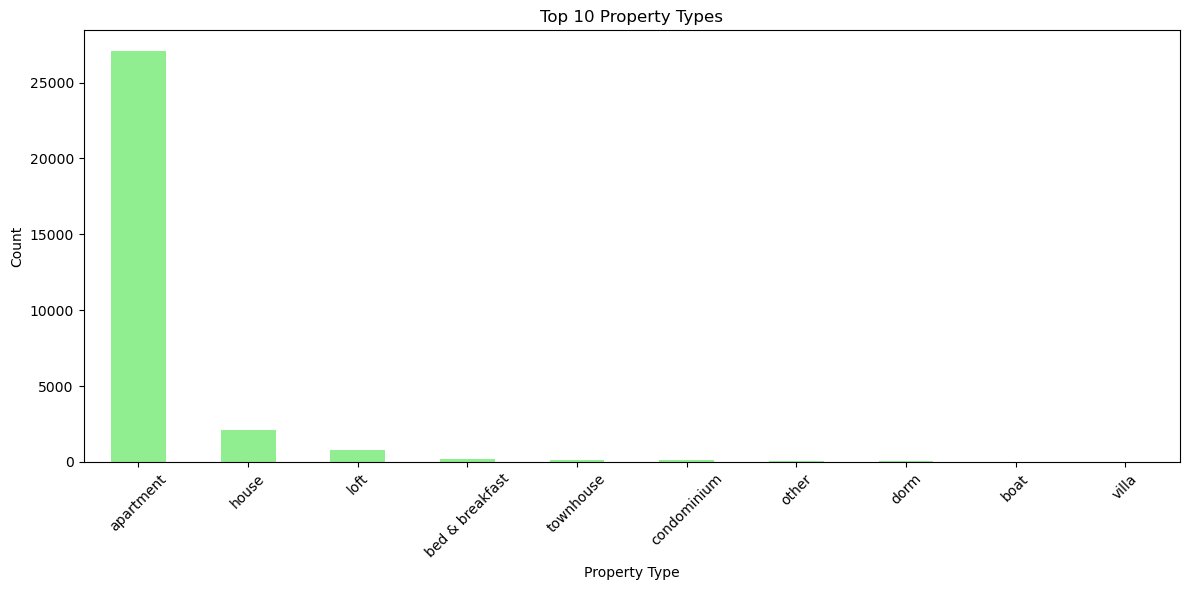

In [28]:
# Room Type popularity by Borough
plt.figure(figsize=(12, 8))
roomtype_by_borough = pd.crosstab(df_clean['Neighbourhood'], df_clean['Room Type'])
roomtype_by_borough.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Room Type Distribution by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

# Property Type popularity
plt.figure(figsize=(12, 6))
property_counts = df_clean['Property Type'].value_counts().head(10)
property_counts.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Property Types')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In graph 1:
            Room Type:
        Room Type
        entire home/apt    17022
        private room       12596
        shared room          839
        Name: count, dtype: int64
        
this is the given data in xlsx file and our stacked bar chart reflects it correctly! representing the relationship between 
listings of Neighbourhood and the room type within them 
                manhattan        16028
                brooklyn         11665
                queens            2274
                bronx              343
                staten island      147


in graph 2 :given property types 
        <Property Type:
        Property Type
        apartment          27084
        house               2087
        loft                 753
        bed & breakfast      180
        townhouse            136>
and as shown by graph also

 Seasonal hosting patterns

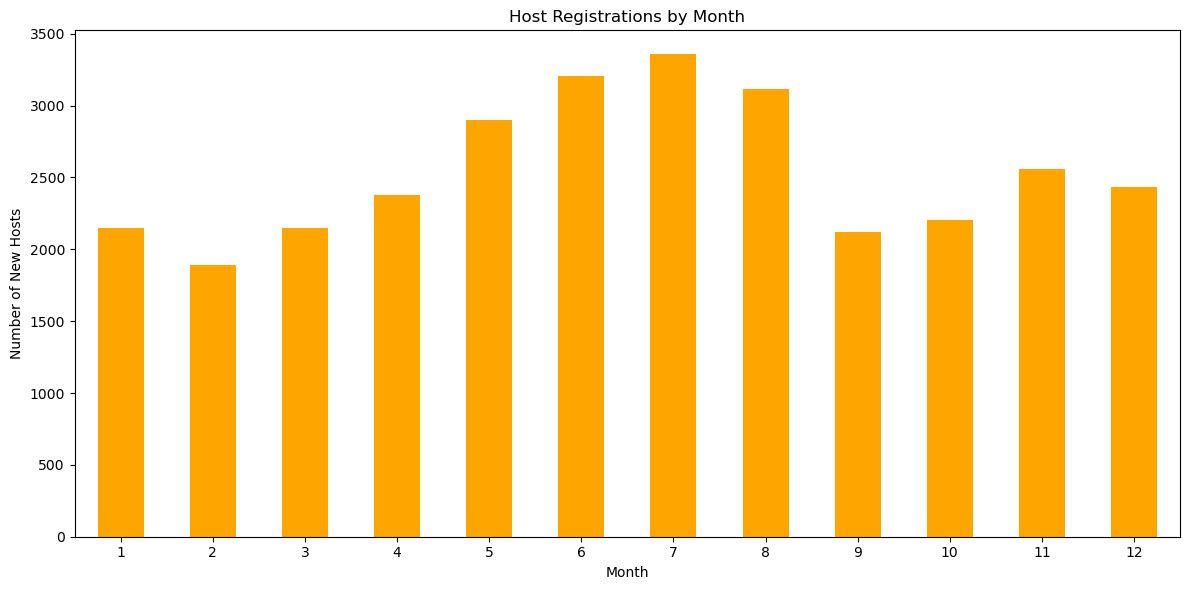

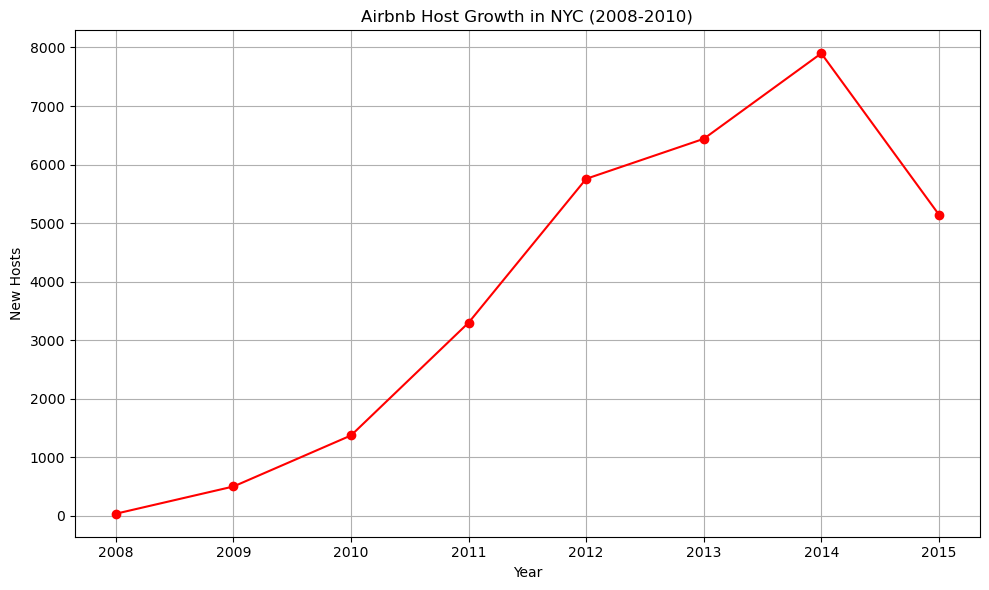

In [29]:
# Host registration patterns by year and month
df_clean['Host_Month'] = df_clean['Host Since'].dt.month
df_clean['Host_Year'] = df_clean['Host Since'].dt.year

# Monthly registration patterns
plt.figure(figsize=(12, 6))
monthly_registrations = df_clean['Host_Month'].value_counts().sort_index()
monthly_registrations.plot(kind='bar', color='orange')
plt.title('Host Registrations by Month')
plt.xlabel('Month')
plt.ylabel('Number of New Hosts')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Yearly growth
plt.figure(figsize=(10, 6))
yearly_growth = df_clean['Host_Year'].value_counts().sort_index()
yearly_growth.plot(kind='line', marker='o', color='red')
plt.title('Airbnb Host Growth in NYC (2008-2010)')
plt.xlabel('Year')
plt.ylabel('New Hosts')
plt.grid(True)
plt.tight_layout()
plt.show()

Graph1: Shows the monthly variation of hosts, where hosts are on y axis and months by x-axis. in this bivariate visualization 
we can see hosts are increased the most in the 7th month as shown by the bar chart.

In Graph2 :
    we are having a bivate relationship between years and hosts
    where years are on x axis and hosts number on y asix
    from the shown line plot we can clearly see that in 2014 we have the highest number of hosts that is 8000
    the hosts number started to increse in rapidly after 2010 and decline after 2014
    the rapid decline as shown was of 8000 to 5000 between 2014 and 2015

HOSTING BUSINESS INSIGHTS
4. How hosts manage multiple properties
Multivariate Analysis

Hosts with multiple properties: 3471
Average properties per multi-property host: 2.74


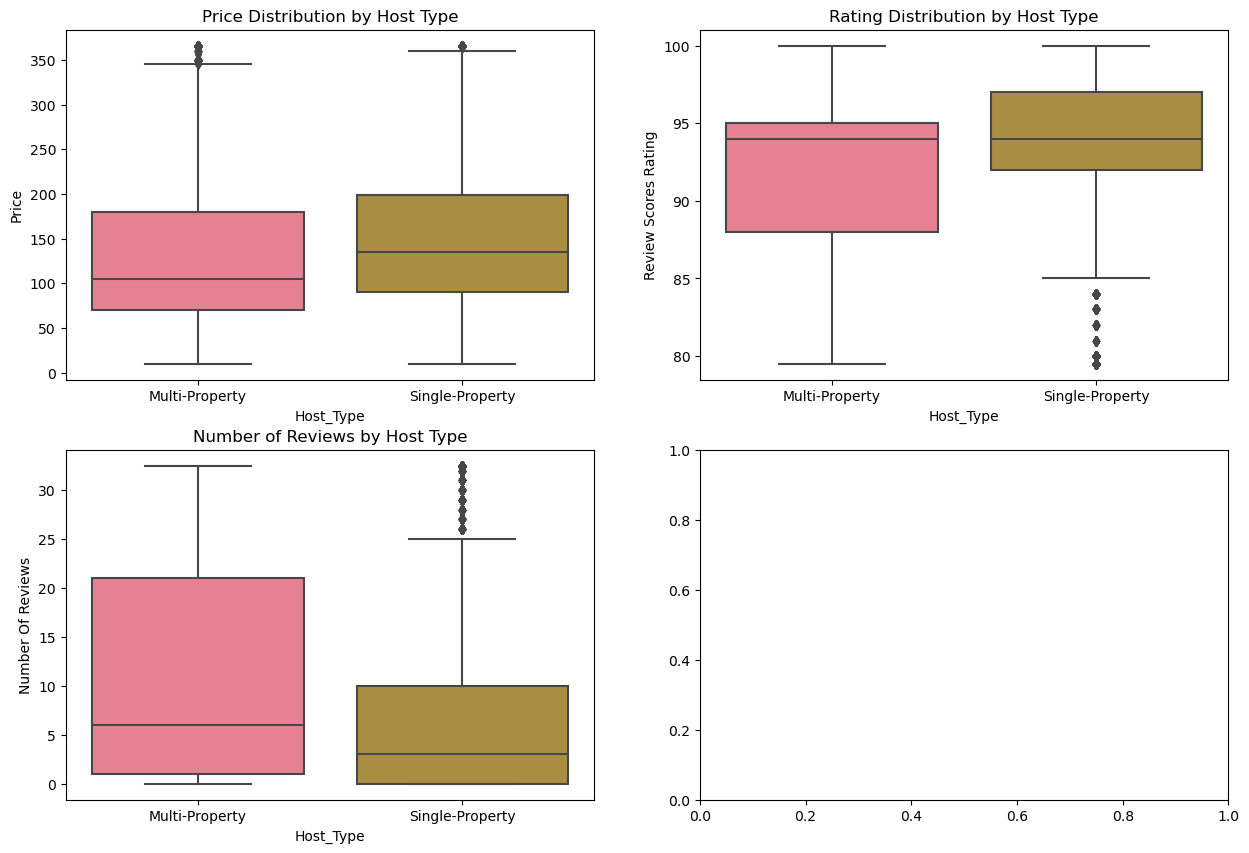

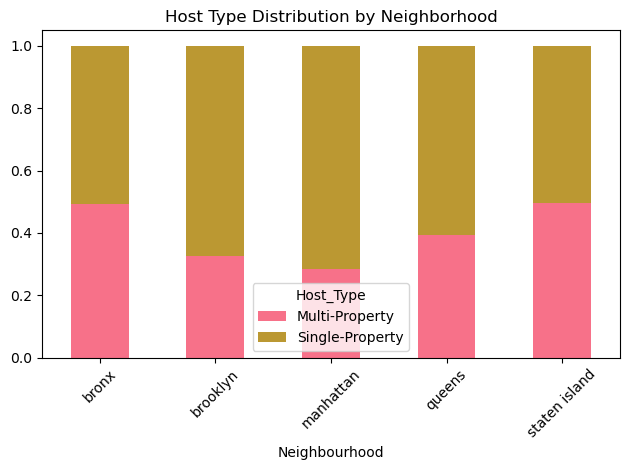

In [30]:
# Identify hosts with multiple properties
host_property_count = df_clean['Host Id'].value_counts()
multi_property_hosts = host_property_count[host_property_count > 1]

print(f"Hosts with multiple properties: {len(multi_property_hosts)}")
print(f"Average properties per multi-property host: {multi_property_hosts.mean():.2f}")

# Analyze multi-property hosts vs single-property hosts
df_clean['Host_Type'] = df_clean['Host Id'].map(
    lambda x: 'Multi-Property' if host_property_count[x] > 1 else 'Single-Property'
)

# Compare performance metrics
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=df_clean, x='Host_Type', y='Price')
plt.title('Price Distribution by Host Type')

plt.subplot(2, 2, 2)
sns.boxplot(data=df_clean, x='Host_Type', y='Review Scores Rating')
plt.title('Rating Distribution by Host Type')

plt.subplot(2, 2, 3)
sns.boxplot(data=df_clean, x='Host_Type', y='Number Of Reviews')
plt.title('Number of Reviews by Host Type')

plt.subplot(2, 2, 4)
host_type_neighborhood = pd.crosstab(df_clean['Neighbourhood'], df_clean['Host_Type'], normalize='index')
host_type_neighborhood.plot(kind='bar', stacked=True)
plt.title('Host Type Distribution by Neighborhood')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In the above visualizations we are seeing different attributes related to airbnb categorized in two hosts types
    1. multi-property
    2. single-property

-According to graph (bos plot) the single-property hosts are more high avg price than multi-property hosts
-According to graph(box ploy) the single-property hosts are more high ratings than multi-property hosts, but avg is almost same
-According to graph(box ploy) the single-property hosts have less no of reviews than multi-property hosts, also avg is of single-property hosts is low.
-The bar chart tells us about the distribution of multi-property hosts vs  single-property hosts in different neighbourhoods


5. Relationship between price and ratings
Bivariate Analysis

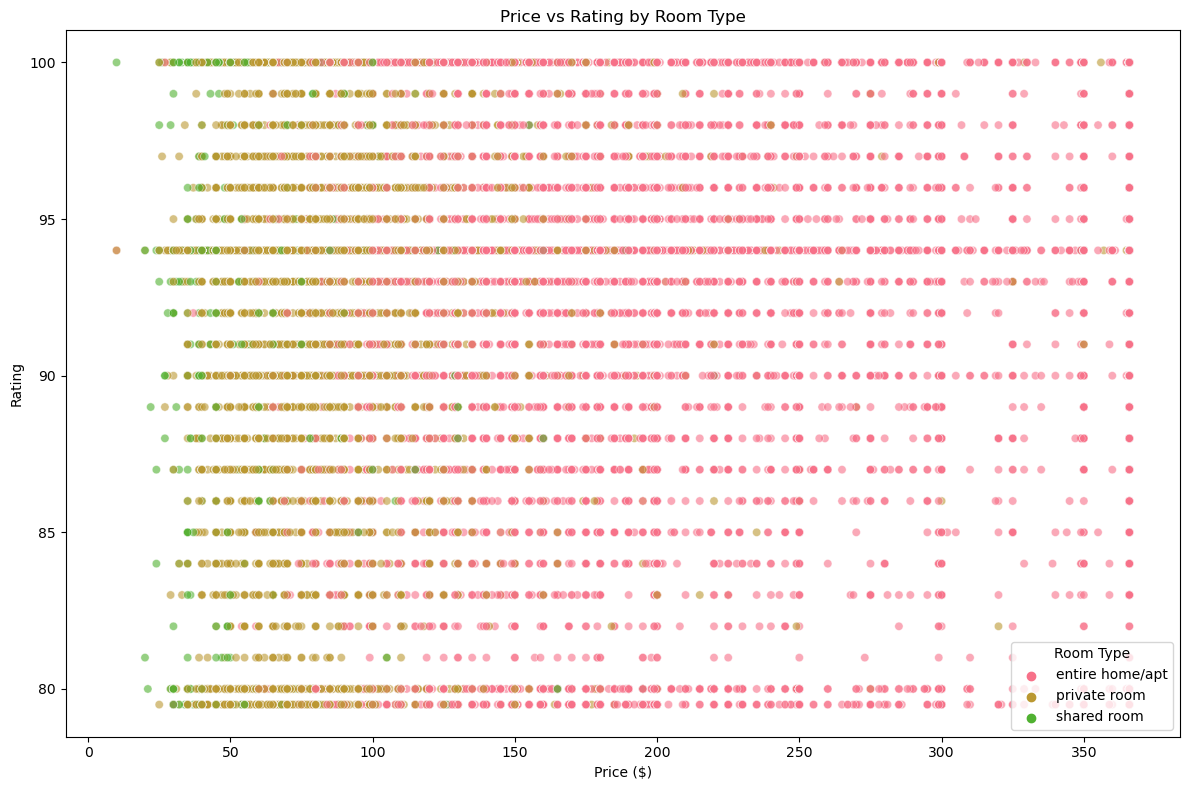

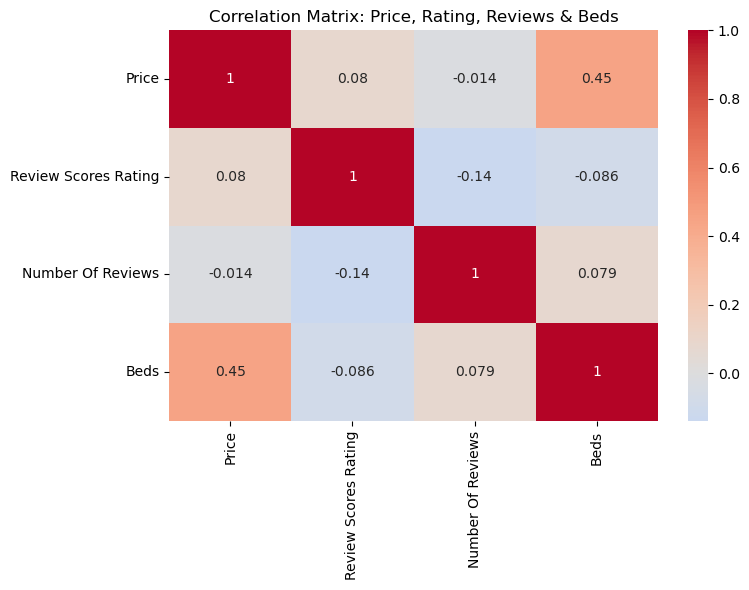

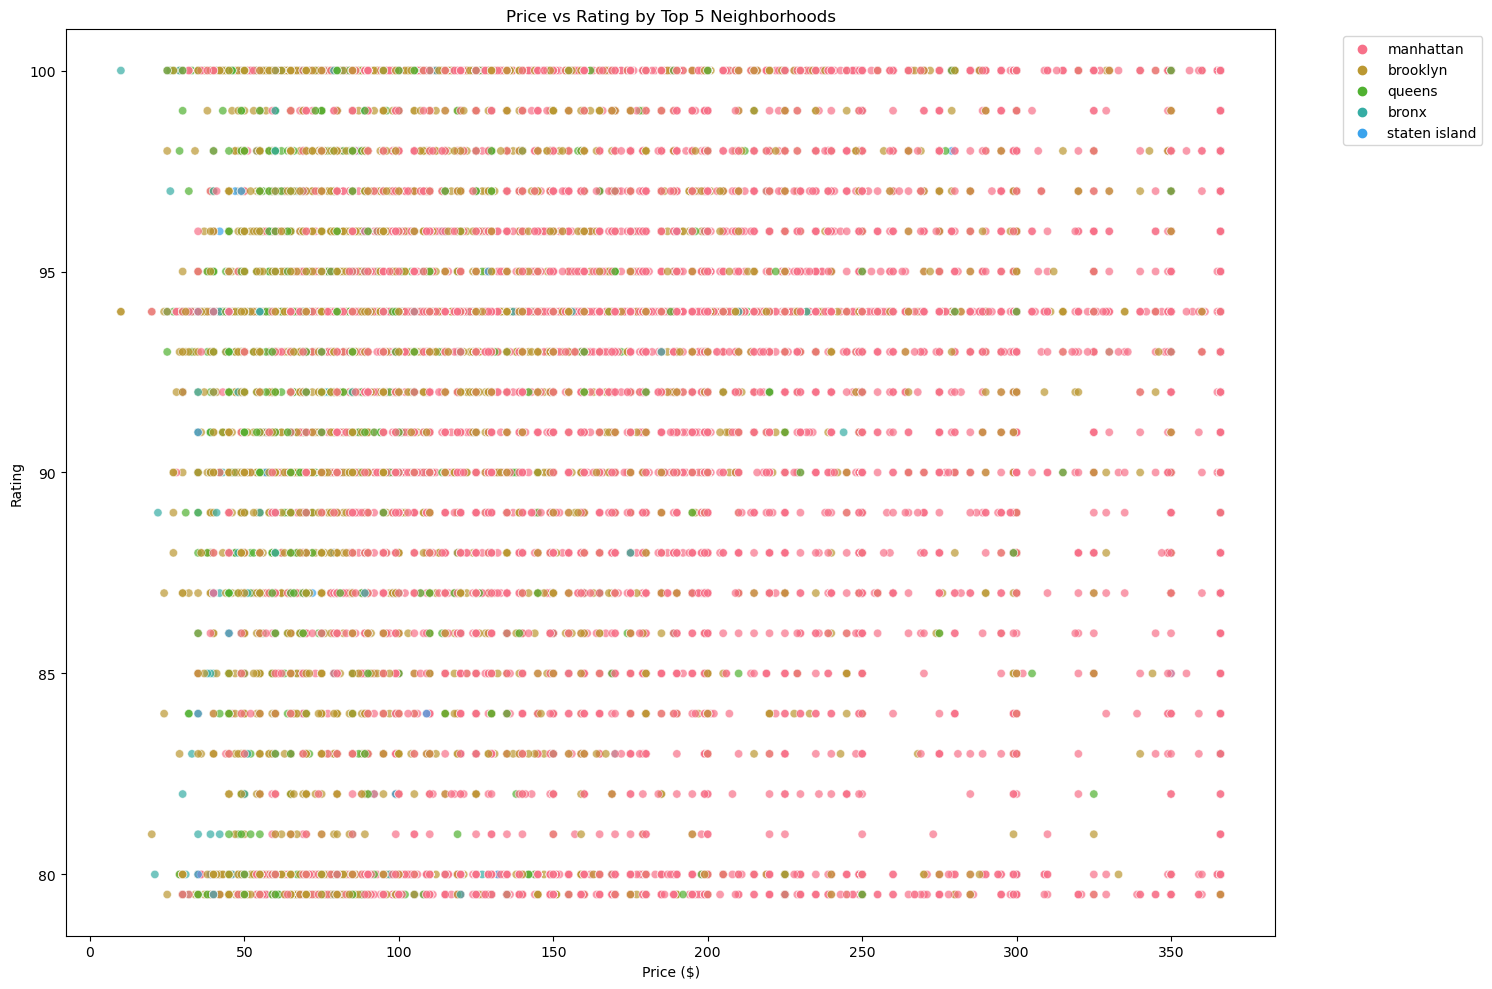

In [31]:
# Scatter plot: Price vs Rating
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clean, x='Price', y='Review Scores Rating', alpha=0.6, hue='Room Type')
plt.title('Price vs Rating by Room Type')
plt.xlabel('Price ($)')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

# Correlation analysis
correlation_matrix = df_clean[['Price', 'Review Scores Rating', 'Number Of Reviews', 'Beds']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Price, Rating, Reviews & Beds')
plt.tight_layout()
plt.show()

# Price vs Rating by Neighborhood
plt.figure(figsize=(15, 10))
top_5_neighborhoods = df_clean['Neighbourhood'].value_counts().head(5).index
df_top5 = df_clean[df_clean['Neighbourhood'].isin(top_5_neighborhoods)]

sns.scatterplot(data=df_top5, x='Price', y='Review Scores Rating', hue='Neighbourhood', alpha=0.7)
plt.title('Price vs Rating by Top 5 Neighborhoods')
plt.xlabel('Price ($)')
plt.ylabel('Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

6. What makes a successful Airbnb listing
Multivariate Analysis

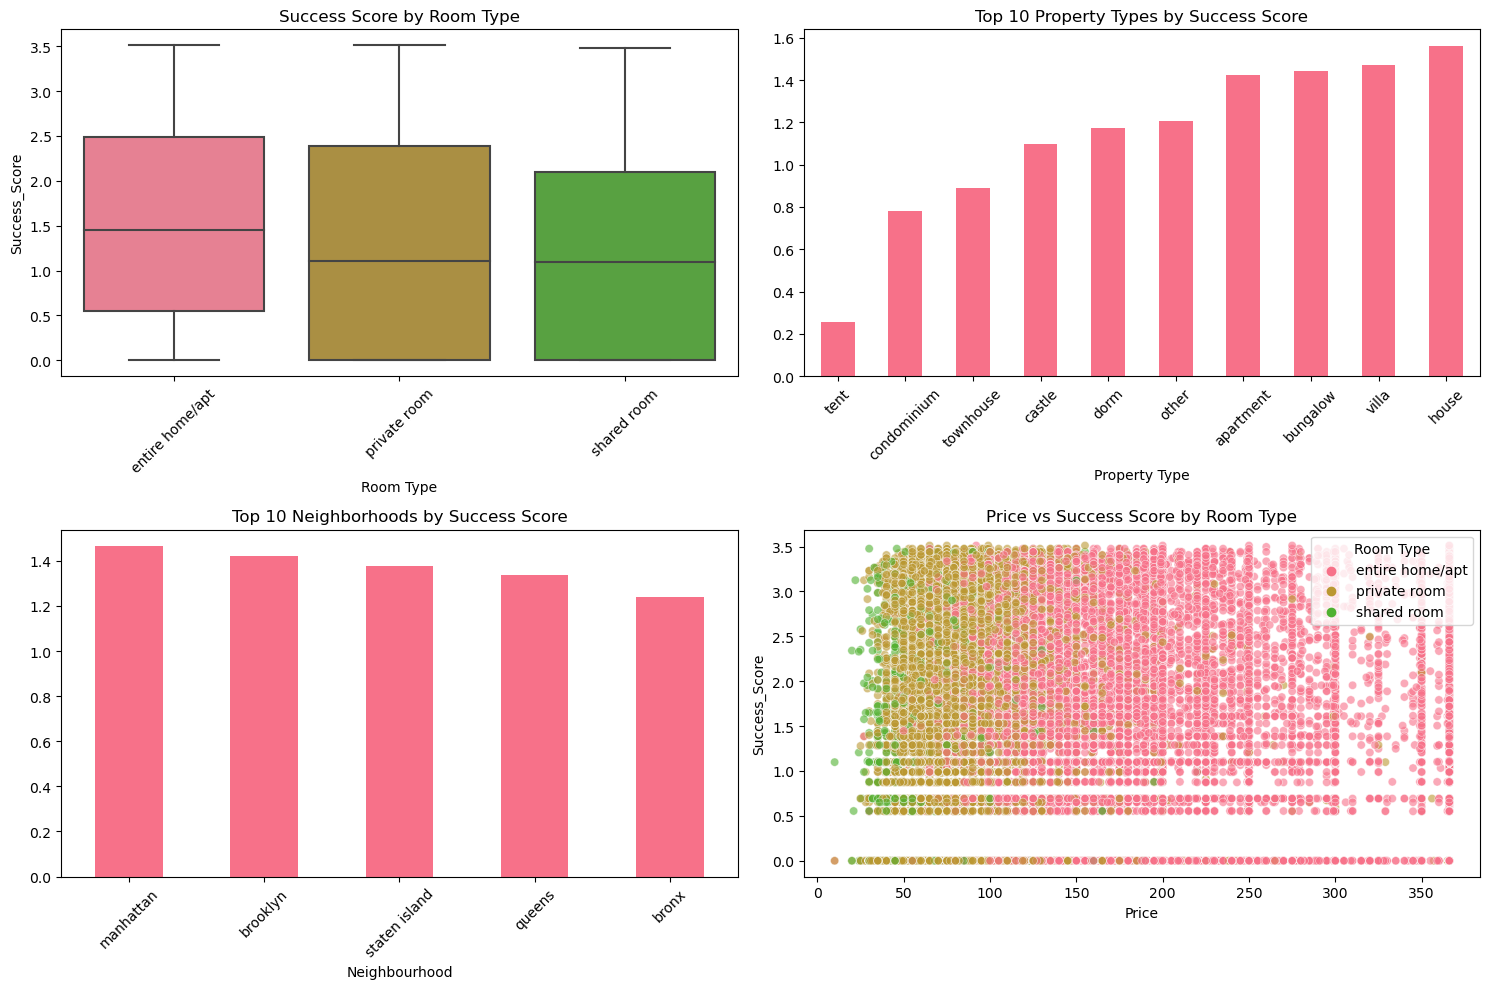

<Figure size 1600x1200 with 0 Axes>

In [43]:
# Define "success" as high ratings AND high number of reviews
df_clean['Success_Score'] = (df_clean['Review Scores Rating'] / 100) * np.log1p(df_clean['Number Of Reviews'])

# Analyze what factors contribute to success
success_factors = df_clean[['Price', 'Beds', 'Room Type', 'Property Type', 'Neighbourhood', 'Success_Score']]

# Success by Room Type
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=df_clean, x='Room Type', y='Success_Score')
plt.title('Success Score by Room Type')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
success_by_property = df_clean.groupby('Property Type')['Success_Score'].mean().sort_values(ascending=True).head(10)
success_by_property.plot(kind='bar')
plt.title('Top 10 Property Types by Success Score')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
success_by_neighborhood = df_clean.groupby('Neighbourhood')['Success_Score'].mean().sort_values(ascending=False).head(10)
success_by_neighborhood.plot(kind='bar')
plt.title('Top 10 Neighborhoods by Success Score')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
# Price vs Success with Room Type
sns.scatterplot(data=df_clean, x='Price', y='Success_Score', hue='Room Type', alpha=0.6)
plt.title('Price vs Success Score by Room Type')

plt.tight_layout()
plt.show()

# Multiple regression-like visualization
fig = plt.figure(figsize=(16, 12))


CONSUMER BEHAVIOR
7. What types of properties get more reviews
Bivariate Analysis

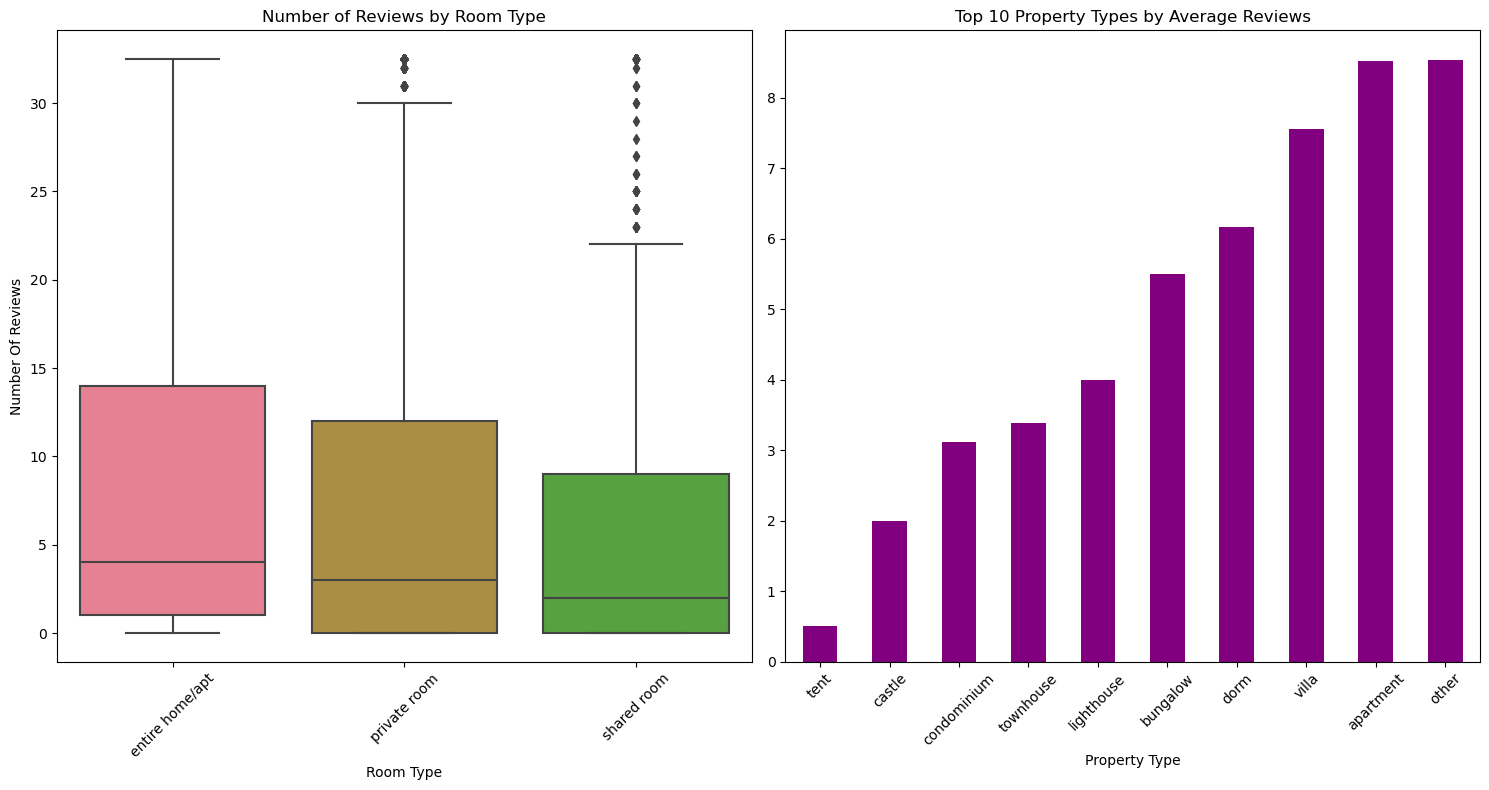

In [44]:
# Reviews by Room Type
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_clean, x='Room Type', y='Number Of Reviews')
plt.title('Number of Reviews by Room Type')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
# Top property types by average reviews
reviews_by_property = df_clean.groupby('Property Type')['Number Of Reviews'].mean().sort_values(ascending=True).head(10)
reviews_by_property.plot(kind='bar', color='purple')
plt.title('Top 10 Property Types by Average Reviews')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


8. Price ranges guests are willing to pay
Bivariate Analysis

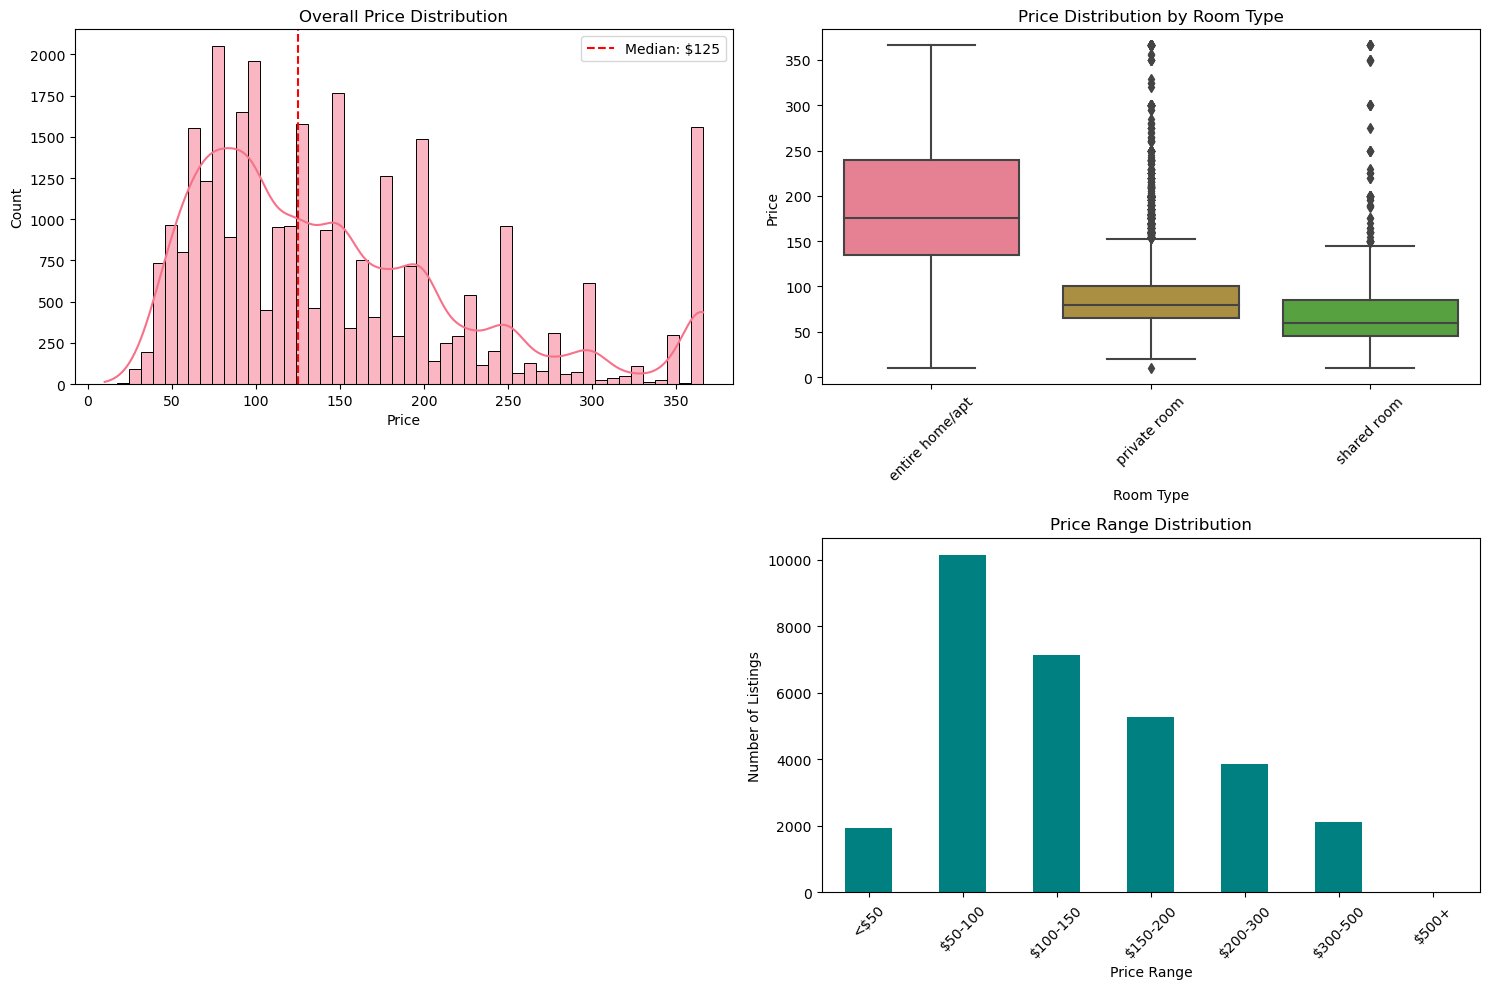

In [50]:
# Price distribution analysis
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
# Overall price distribution
sns.histplot(df_clean['Price'], bins=50, kde=True)
plt.title('Overall Price Distribution')
plt.axvline(df_clean['Price'].median(), color='red', linestyle='--', label=f'Median: ${df_clean["Price"].median():.0f}')
plt.legend()

plt.subplot(2, 2, 2)
# Price by Room Type
sns.boxplot(data=df_clean, x='Room Type', y='Price')
plt.title('Price Distribution by Room Type')
plt.xticks(rotation=45)


plt.subplot(2, 2, 4)
# Price categories distribution
df_clean['Price_Range'] = pd.cut(df_clean['Price'], 
                                bins=[0, 50, 100, 150, 200, 300, 500, float('inf')],
                                labels=['<$50', '$50-100', '$100-150', '$150-200', '$200-300', '$300-500', '$500+'])
price_range_dist = df_clean['Price_Range'].value_counts().sort_index()
price_range_dist.plot(kind='bar', color='teal')
plt.title('Price Range Distribution')
plt.xlabel('Price Range')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

9. Rating patterns and guest satisfaction
Multivariate Analysis

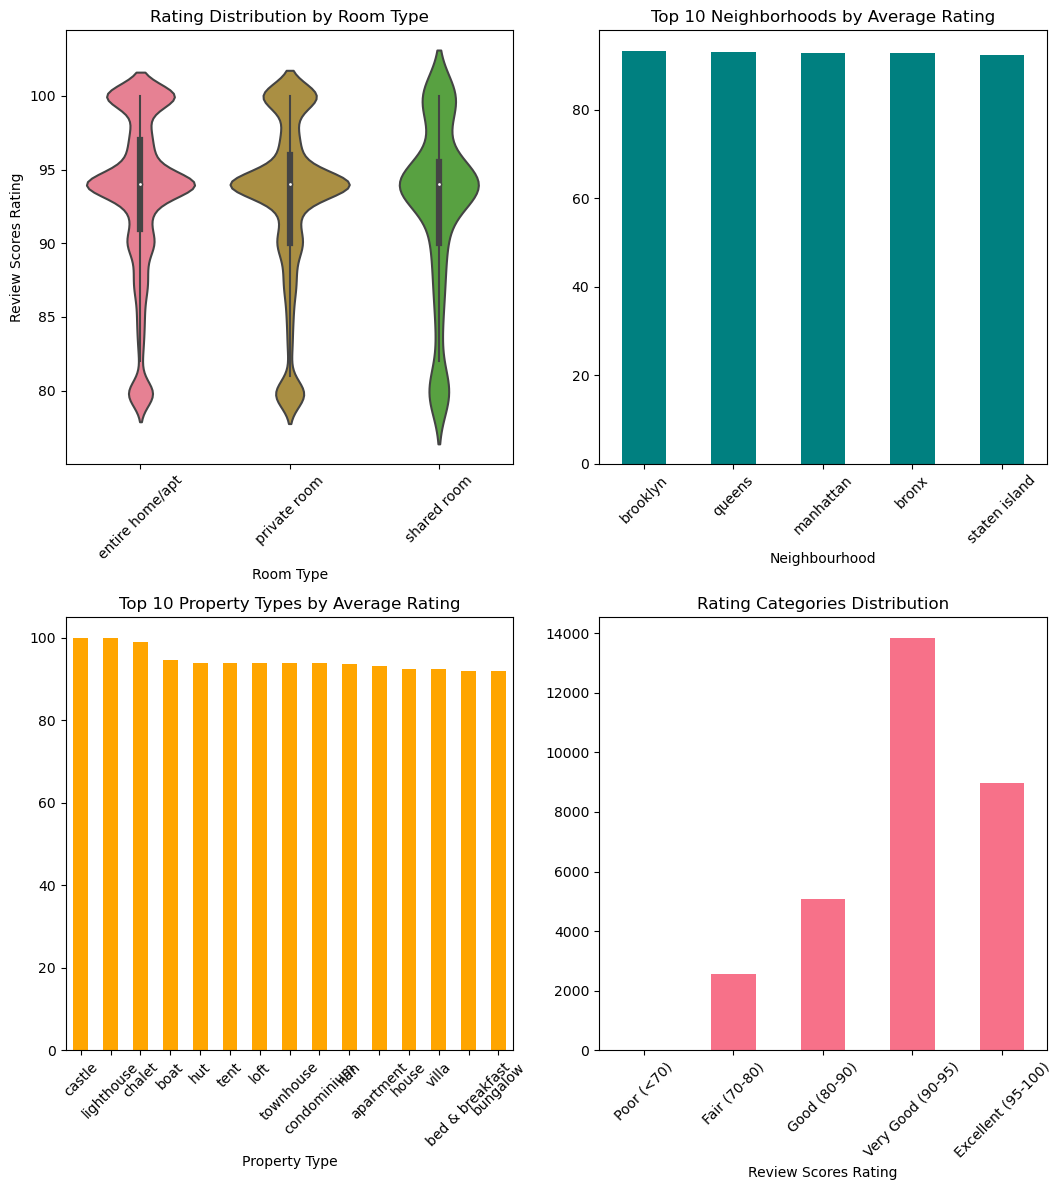

In [57]:
# Comprehensive rating analysis
plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
# Rating distribution by Room Type
sns.violinplot(data=df_clean, x='Room Type', y='Review Scores Rating')
plt.title('Rating Distribution by Room Type')
plt.xticks(rotation=45)

plt.subplot(2, 3, 2)
# Rating by Neighborhood (top 10)
top_neigh_ratings = df_clean.groupby('Neighbourhood')['Review Scores Rating'].mean().sort_values(ascending=False).head(10)
top_neigh_ratings.plot(kind='bar', color='teal')
plt.title('Top 10 Neighborhoods by Average Rating')
plt.xticks(rotation=45)

plt.subplot(2, 3, 4)
# Rating by Property Type (top 10)
top_prop_ratings = df_clean.groupby('Property Type')['Review Scores Rating'].mean().sort_values(ascending=False).head(15)
top_prop_ratings.plot(kind='bar', color='orange')
plt.title('Top 10 Property Types by Average Rating')
plt.xticks(rotation=45)


plt.subplot(2, 3, 5)
# Rating categories distribution
rating_cats = pd.cut(df_clean['Review Scores Rating'], 
                    bins=[0, 70, 80, 90, 95, 100],
                    labels=['Poor (<70)', 'Fair (70-80)', 'Good (80-90)', 'Very Good (90-95)', 'Excellent (95-100)'])
rating_cats.value_counts().sort_index().plot(kind='bar')
plt.title('Rating Categories Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

NEIGHBORHOOD COMPARISONS
10. Which areas have more Airbnb activity
Bivariate Analysis

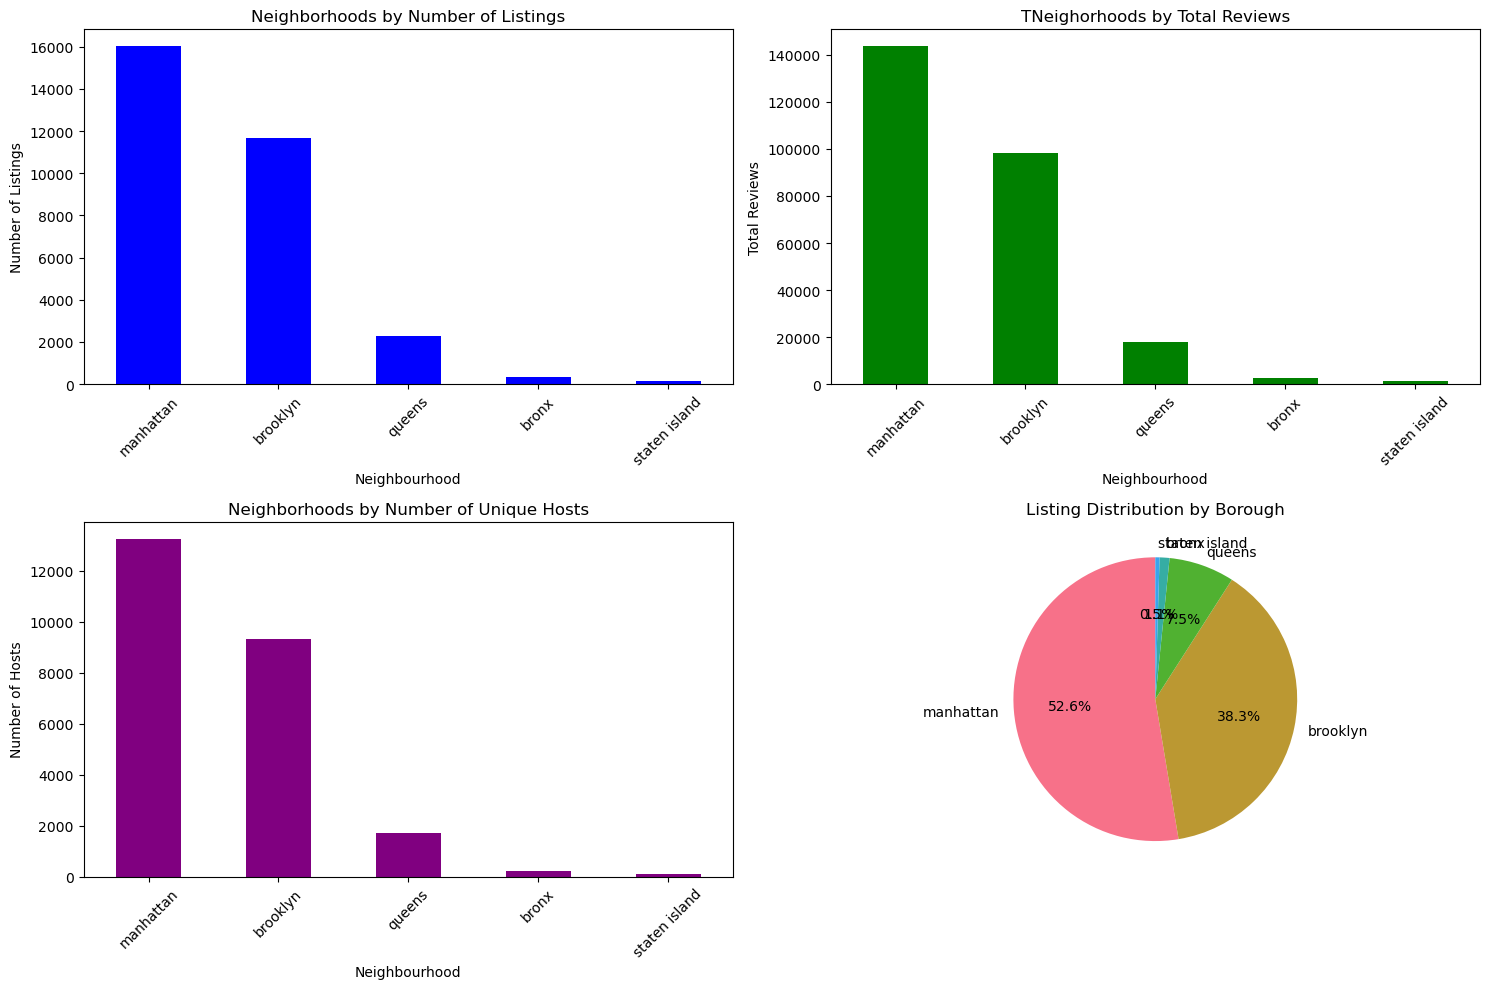

In [59]:
# Airbnb activity by neighborhood
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
# Listing count by neighborhood
neighborhood_activity = df_clean['Neighbourhood'].value_counts()
neighborhood_activity.plot(kind='bar', color='blue')
plt.title('Neighborhoods by Number of Listings')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
# Reviews by neighborhood (engagement metric)
reviews_by_neighborhood = df_clean.groupby('Neighbourhood')['Number Of Reviews'].sum().sort_values(ascending=False)
reviews_by_neighborhood.plot(kind='bar', color='green')
plt.title('TNeighorhoods by Total Reviews')
plt.ylabel('Total Reviews')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
# Host concentration by neighborhood
hosts_by_neighborhood = df_clean.groupby('Neighbourhood')['Host Id'].nunique().sort_values(ascending=False)
hosts_by_neighborhood.plot(kind='bar', color='purple')
plt.title('Neighborhoods by Number of Unique Hosts')
plt.ylabel('Number of Hosts')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
# Borough distribution
borough_dist = df_clean['Neighbourhood'].value_counts()
borough_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Listing Distribution by Borough')
plt.ylabel('')

plt.tight_layout()
plt.show()

11. Price variations by location
Multivariate Analysis

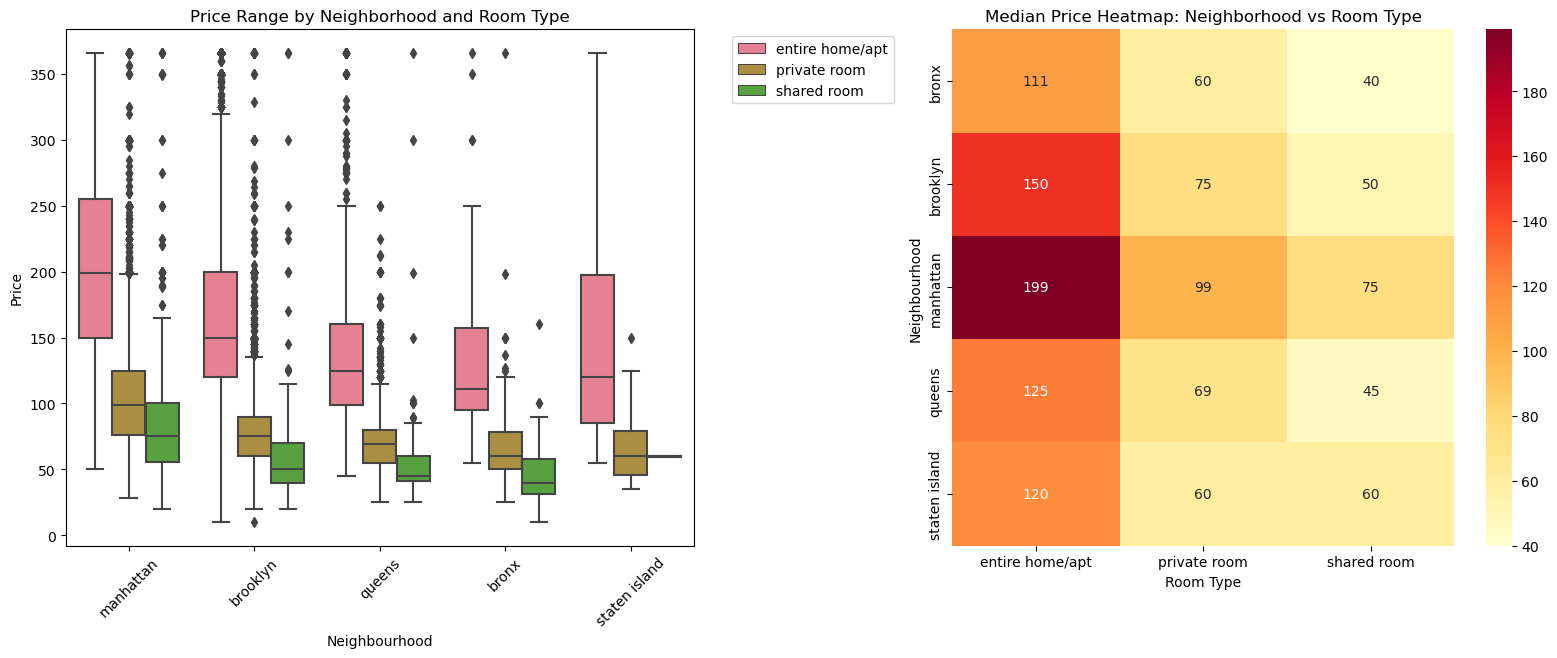

In [60]:
# Advanced price variation analysis
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
# Price range by Room Type and Neighborhood
top_5_neigh = df_clean['Neighbourhood'].value_counts().head(5).index
df_top5_price = df_clean[df_clean['Neighbourhood'].isin(top_5_neigh)]
sns.boxplot(data=df_top5_price, x='Neighbourhood', y='Price', hue='Room Type')
plt.title('Price Range by Neighborhood and Room Type')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(2, 2, 2)
# Price heatmap by Neighborhood and Room Type
price_pivot = df_clean.pivot_table(values='Price', index='Neighbourhood', columns='Room Type', aggfunc='median')
sns.heatmap(price_pivot, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Median Price Heatmap: Neighborhood vs Room Type')
plt.tight_layout()

plt.tight_layout()
plt.show()